## 3) First Machine Learning Model

**The table of contents**:
<br> - 3.1 Import libraries
<br> - 3.2 General Functions for ML Models
<br> - 3.4 Cost Functions
<br> - 3.5 Split Train/Test Data
<br> - 3.6 Baseline for the Models
<br> - 3.7 Data Preparation
<br> - 3.8 PCA
<br> - 3.9 Linear Regression Method:
> -3.9.1  Simple Method: Linear Regression
<br> -3.9.1  Ridge Regression: alpha Grid Optimization

<br> 3.10 - K-NN --> **See other file: 03.1.Knn-ML-jeromeaubry.ipynb**
<br> 3.11 - Non-Linear Approach: SVR: Supervised Vector Machine Approach for Regression
<br> 3.12 - Non Linear Approach: Random Forest 
<br> 3.13 - Gradient Boosting
<br> 3.14 - Save Results


### 3.1. Import Libraries

In [12]:
# Import librairies
import os
import pandas as pd
import numpy as np

#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint

In [13]:
# Import the necessary librairires for model fitting.

from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.metrics import r2_score 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#from tune_sklearn import TuneSearchCV
from sklearn.linear_model import LinearRegression, Ridge


import warnings
from scipy.linalg import LinAlgWarning

In [14]:
# Take seaborn as preference graphic interface
sns.set()

In [15]:
# Load Main data & Save Models in the following folders
path_main_save = '/Users/jeromeaubry/Chap5.1-Proposal-Capstone/Data/'
path_secondary_save = 'US_Pesticide/2015PDPDatabase/SaveModels/'

path_save = os.path.join(path_main_save,path_secondary_save)
os.chdir(path_save)
os.getcwd()

'/Users/jeromeaubry/Chap5.1-Proposal-Capstone/Data/US_Pesticide/2015PDPDatabase/SaveModels'

### 3.2 General Functions for ML Models

In [16]:
def sortout_data(parameter, grid, grid_search, log=False):

    #Prepare the dataframe based on cv_results._keys()
    
    items_col = ['mean_test_neg_mean_squared_error','std_test_neg_mean_squared_error',
                 'mean_train_neg_mean_squared_error','std_train_neg_mean_squared_error',
                'mean_test_r2', 'std_test_r2','mean_train_r2','std_train_r2']

    cols = []

    for item in items_col:
        if item not in cols:
            cols.append(item)
    
    # Incorporate the paramaters from the grid to the cv_results dataframe
    
    col_grid = list(grid.keys()) 
    col_grid = ['param_' + c for c in col_grid] # Add 'param_'
    col_grid = sorted(col_grid)
    cols.extend(col_grid) 
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results = cv_results.loc[:, cols]
    cv_results = cv_results.loc[:,::-1] # Reverse the columns
    cv_results.columns = cv_results.columns.str.replace('neg_mean_squared_error','MSE')#rename the columns
    
    # Grid/RandomizeSearch displays negative values due to maximize per definition, when minimize negative values
    cv_results[['mean_train_MSE','mean_test_MSE']] = cv_results[['mean_train_MSE','mean_test_MSE']].abs() #negative value into positive values
    
    for item in cv_results.columns: #Extract the columns name for the parameter
        if ('param' in item):
             # For example from param_Ridge__alpha: alpha; from Ridge__alpha:alpha check alpha=alpha
                if (item.split('__')[1] == parameter.split('__')[1]): 
                    item_param = item
        
    grouped = cv_results.groupby(item_param) # Sort out the data based on parameters

     # Train data -R2/MSE
    mean_train_r2 = grouped.mean_train_r2.mean()
    std_train_r2 = grouped.std_train_r2.mean()
    mean_train_MSE = grouped.mean_train_MSE.mean()
    std_train_MSE = grouped.std_train_MSE.mean()

    #Test data -R2/MSE
    mean_test_r2 = grouped.mean_test_r2.mean()
    std_test_r2 = grouped.std_test_r2.mean()
    mean_test_MSE = grouped.mean_test_MSE.mean()
    std_test_MSE = grouped.std_test_MSE.mean()
    
    param = mean_test_r2.index.values # Gather the parameters for plotting
    best_param= mean_test_r2.idxmax() # Extract the best_parameter for plotting

    best_output = grouped.get_group(best_param) # Take the best values from the dataset based on best param
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    
    # Plot R2/MSE vs parameter
    if log==True:
        # Logarithmn scale
        ax[0].semilogx(param, mean_train_r2, color='blue', alpha=0.5, label='Train')
        ax[0].semilogx(param, mean_test_r2, color='orange', alpha=0.5, label='Validation')
        x_axis = 'log({})'.format(parameter)
       
        ax[1].semilogx(param, mean_train_MSE, color='blue', alpha=0.5, label='Train')
        ax[1].semilogx(param, mean_test_MSE, color='orange', alpha=0.5, label='Validation')
        
    
    else: # Not a logarithmn scale
        ax[0].plot(param, mean_train_r2, alpha=.5, color='blue', label='Train')
        ax[0].plot(param, mean_test_r2, alpha=.5, color='red', label='Validation')
        x_axis = '{}'.format(parameter)
        
        ax[1].plot(param, mean_train_MSE, alpha=.5, color='blue', label='Train')
        ax[1].plot(param, mean_test_MSE, alpha=.5, color='red', label='Validation')
    

    
    # Plot R2
    ax[0].fill_between(param, mean_train_r2 - std_train_r2,  mean_train_r2 + std_train_r2, alpha=0.5)
    ax[0].fill_between(param, mean_test_r2 - std_test_r2,  mean_test_r2 + std_test_r2, alpha=0.5)
    ax[0].scatter(best_param, mean_test_r2.max(), marker='x', color='red', zorder=10, label='Max_Validation')
    ax[0].legend()
    ax[0].set_xlabel(x_axis)
    ax[0].set_ylabel('$R^2$')
    ax[0].set_title('best valid accuracy with {}={:.0f} \n gives  test_r2 = {:.3f} ± {:.3f} - mean/std'.
                  format(parameter,
                         grid_search.best_params_[parameter], 
                         mean_test_r2[best_param],
                         std_test_r2[best_param]))

    
    # Plot MSE
    ax[1].fill_between(param, mean_train_MSE - std_train_MSE,  mean_train_MSE + std_train_MSE, alpha=0.5)
    ax[1].fill_between(param, mean_test_MSE- std_test_MSE,  mean_test_MSE + std_test_MSE, alpha=0.5)
    ax[1].scatter(best_param, mean_test_MSE.min(), marker='x', color='red', zorder=10, label='Max_Validation')
    ax[1].legend()
    ax[1].set_xlabel(x_axis)
    ax[1].set_ylabel('$MSE$')
    ax[1].set_title('best MSE with {}={:.0f} \n gives  test_MSE = {:.3f} ± {:.3f} - mean/std'.
                  format(parameter,
                         grid_search.best_params_[parameter],
                         mean_test_MSE[best_param],
                         std_test_MSE[best_param]))


    plt.subplots_adjust(wspace=0.2, hspace=0.2) 
    plt.show()
    
    best_output.columns = cv_results.columns.str.replace('test','validation')#rename the columns
    best_output['Model'] = parameter.split('__')[0] #Retrieve the name of the model
    

    return best_output

In [17]:
def sortout_params(grid, grid_search):
    
    print('Best parameters: {}'.format(grid_search.best_params_))
    print('-'*50)
    print('Best estimators: {}'. format(grid_search.best_estimator_))
    print('-'*50)
    print('Best score: {}'. format(grid_search.best_score_))
    print('-'*50)
    params = sorted(list(grid.keys())) #List the parameters from the grid for feeding the parameter from sortout_data function
    
    return params

### 3.3 Load the data 

In [18]:
# Load the data
#with np.load('data_pesticides_binarycoding.npz', allow_pickle=True) as npz_data:
with np.load('data_pesticides_option3_EDA_1.npz', allow_pickle=True) as npz_data:
    print(list(npz_data.keys()))
    df = dict(npz_data.items())
    
# option 1: Sample data: 38751 column 'concen' and take only non zeros values ()  ---> Proposal
# option 2: All the data 2M (100% of the dataset, 98.5% 0-values, 1.5% non-zeros values) ---> EDA 
# option 3: Sample data: around 100'000 - 5% of the dataset (mix zeros and non zeros in same ratio than option2 )---> ML Models

['data', 'target', 'labels']


In [19]:
# Define X and y values
X = df['data']
y = df['target']
labels = df['labels']

### 3.4 Cost Functions

In [20]:
def MSE(y,y_pred):
    return np.mean(np.square(y-y_pred))

In [21]:
# Define Mean Absokute Error 
def MAE (y,y_pred):
    return np.mean(np.absolute(y-y_pred))

In [22]:
def RSS (y,y_pred):
    return np.sum(np.square(y-y_pred))

In [23]:
def R2 (y,y_pred):
    return r2_score(y,y_pred)

> **Remarks**:
<br> - The chosen cost function is MSE: Mean Square Error as being a metrics given enough statistical information
<br> - Beside MSE; R2 will also be computed but as information only

### 3.5 Split Train/Test Data

In [24]:
# Convert X as float 
X = X.astype(float)

In [25]:
# Split the data train/test for the simple model 70/30% train/test
X_tr, X_te, y_tr, y_te = train_test_split(X,y, test_size=0.3, random_state=0)

In [26]:
# Check out the dimension of the 

print('-'*80)
print('Dimension of the train data: X_tr={}; y_tr={}'.format(X_tr.shape, y_tr.shape))
print('Dimension of the test data: X_te={}; y_te={}'.format(X_te.shape, y_te.shape))
print('-'*80)
print('Data type for the train data: X_tr={}; y_tr={}'.format(X_tr.dtype, y_tr.dtype))
print('Data type for the test data: X_te={}; y_te={}'.format(X_te.dtype, y_te.dtype))
print('-'*80)

--------------------------------------------------------------------------------
Dimension of the train data: X_tr=(81431, 85); y_tr=(81431,)
Dimension of the test data: X_te=(34899, 85); y_te=(34899,)
--------------------------------------------------------------------------------
Data type for the train data: X_tr=float64; y_tr=float64
Data type for the test data: X_te=float64; y_te=float64
--------------------------------------------------------------------------------


In [27]:
# The rumber of 0s and non-0s values express in % per column of the train dataset

y_tr_0s_vals = np.count_nonzero(y_tr==0)
y_tr_no0s_vals = np.count_nonzero(y_tr!=0)

print('Number of 0s value in train data: {} and in percent of the dataset {:.2f}%'. 
      format(y_tr_0s_vals, 100*y_tr_0s_vals/len(y_tr)))
print('Number of non-0s value in train data: {} and in percent of the dataset {:.2f}%'. 
      format(y_tr_no0s_vals, 100*y_tr_no0s_vals/len(y_tr)))


Number of 0s value in train data: 80097 and in percent of the dataset 98.36%
Number of non-0s value in train data: 1334 and in percent of the dataset 1.64%


In [28]:
# The rumber of 0s and non-0s values express in % per column of the test dataset

y_te_0s_vals = np.count_nonzero(y_te==0)
y_te_no0s_vals = np.count_nonzero(y_te!=0)

print('Number of 0s value in test data: {} and in percent of the dataset {:.2f}%'. 
      format(y_te_0s_vals, 100*y_te_0s_vals/len(y_te)))
print('Number of non-0s value in test data: {} and in percent of the dataset {:.2f}%'. 
      format(y_te_no0s_vals, 100*y_te_no0s_vals/len(y_te)))

Number of 0s value in test data: 34310 and in percent of the dataset 98.31%
Number of non-0s value in test data: 589 and in percent of the dataset 1.69%


> **Remarks**:
<br> - Sample n=5% -option3- expects to find same ratio for the test/train dataset, i.e, 1.66% non zeros values. If it is the case, it means that the full dataset -option 2- can be replaced by option3 for the computations of the ML as being less time consuming.
<br> - Option 1 has been used for the first pre-models validation giving the best results since dealing with non zero values but it is not representative of the the full data set.

### 3.6 Baseline for the Models

In [18]:
# MSE as baseline for the models 

y_pred = np.mean(y_tr)

#MAE_baseline = MAE(y_te, y_pred)
MSE_baseline = MSE(y_te, y_pred)
#rss_baseline = RSS(y_te,y_pred)

print('-'*50)
#print('Baseline MAE: {:.2f} in ppm'.format(MAE_baseline))
print('Baseline MSE: {:.6f}'.format(MSE_baseline))
#print('Baseline R2: {:.2f}'.format(rss_baseline))
print('-'*50)

--------------------------------------------------
Baseline MSE: 0.006619
--------------------------------------------------


In [19]:
results_baseline = pd.DataFrame({'Model': 'Baseline',
                                'mean_test_MSE': [MSE_baseline]})
results_baseline

,Model,mean_test_MSE
0,Baseline,0.006619


> **Strategies**:
<br> - The chosen metrics for going through the different regression models is MSE - Mean Square Error- by also displaying the R2 results for comparison purposes.
<br> - The simplest choice for the baseline is the average of the training data to provide a first MSE result between prediction and test data. Since the 0s values represent almost 99% of the values, the MSE is very low.
<br> - **It was not possible to run with the complete dataset for the ML models due to its size**; the EDA has been done with the full dataset as per option2, while the ML models section is done with a data sampling of 5% -option 3- of the full data keeping the same ratio of zeros and non-zeros values as the statistics shows it in rows 27 28.
<br> - In addition, a comparison was made for the EDA between the complete dataset and the 5% data sampling showing the same trend of results leading to conclude to replace the full data with the sampling option is a reasonable approach for the ML calculations.
<br> - The investigation starts with a PCA analysis, if possible, to reduce the dimension or not based on the variance ratio.
<br> - Then, a simple linear regression is applied, followed by a Ridge regression to check if the dataset could be linear or not and if we improve the analysis by tuning the regularization parameter of the Ridge regression.
<br> - Then, the linear approach is cross-checked with another linear algo, such as knn, although it was very time-consuming to run it.
<br> - The next step consists of checking with a non-linear approach such as SVR using a non-linear kernel - kbf - to see if we can improve the results.
<br> - Finally, the last part is to check if the model on the dataset overfits or not by considering a random approach such as random forest and by consolidating the results with an iterative approach such as the gradient boosting method.
<br> - For speeding up the process, all the models are optimized with grid search `RandomizedGridSearch` using random selection based on r2, MSE optimization, and refit on r2 for the maximization:  https://scikit-learn.org/stable/modules/model_evaluation.html.  
<br> - All the models are normalized via the `Standardscale` function.

### 3.7 Data Preparation

In [31]:
# Scale the data between 0 and 1 for the pipeline models
scale = StandardScaler()

In [32]:
# Use RandomState for reproducibility / not necessary could be random_state=1 for example, needs a value for reproducibility
random_state = np.random.RandomState(42)

### 3.8 PCA Principal Component Analysis

In [22]:
from sklearn.decomposition import PCA

In [23]:
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

X_tr_scaled = scale.fit_transform(X_tr)

In [24]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X_tr_scaled)

In [25]:
pca.explained_variance_ratio_

array([0.03812113, 0.03528068])

In [26]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_tr_scaled)

In [27]:
print(len(pca.explained_variance_ratio_))

66


In [28]:
# no axis
pca_all = PCA(n_components=None)
pca_all.fit(X_scaled)
var_all = pca_all.explained_variance_ratio_
var_all.shape

(85,)

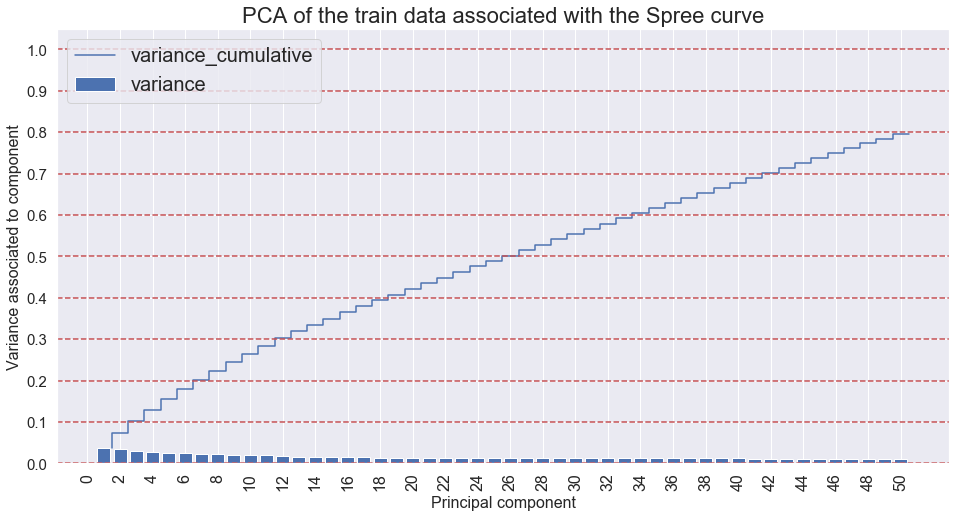

In [29]:
'''
Spree plots considering the first 50 PCA components
'''
N= 50 #50 first components 

fig=plt.figure(figsize=(16,8))

xcor = np.arange(1 , len(var_all[0:N])+1)
plt.bar(xcor,var_all[0:N],label='variance')
plt.xticks(xcor,rotation=90)


var_cumulative = np.cumsum(var_all[0:N])

plt.step(
    xcor + 0.5,
    var_cumulative,
    label='variance_cumulative'
)
for i in range(0,11,1):
    i/=10
    plt.axhline(y=i, color='r', linestyle='--')

plt.xticks(np.arange(0,52,2))
plt.yticks(np.arange(0,1.1,0.1))

plt.title('PCA of the train data associated with the Spree curve', fontsize=22)
plt.xlabel('Principal component', fontsize=16)
plt.ylabel('Variance associated to component', fontsize=16)
plt.legend(fontsize=20, loc='upper left')


plt.xticks(fontsize=16)
plt.yticks(fontsize=15)


plt.show()

In [30]:
'''
How many PCA components explain 10%, 20%, …, 90% and 100% of the variance
'''

variance_percent = [x for x in range(10, 110, 10)]
var_cumulative_all = np.cumsum(var_all)

nearest_value_cumulative = []

for i in range(1, 11, 1):
    i/=10
    
    #retrieve the index from the nearest variance value
    idx_all = np.abs(var_cumulative_all-i).argmin()+1
    nearest_value_cumulative.append(idx_all)

nearest_value_cumulative = pd.DataFrame({
    'variance in %' : variance_percent,
    'Number of PCA components': nearest_value_cumulative
    
})

nearest_value_cumulative.set_index('variance in %')

,Number of PCA components
variance in %,
10,3
20,7
30,12
40,18
50,26
60,34
70,42
80,50
90,60


> **Remarks**:
<br> - The data projection onto orthogonal axes (hyperplans) for displaying the variance as function of the number of dimensions shows that most of the dimension must be kept for the present training data for retrieving enough variance.
<br> - To reduce the dimension down to 2 or 3 would impact too much the variance results and the results of the ML models. It has been decided to keep the data as it is and not used the PCA dimension reduction for the ML models.

### 3.9 Linear Regression Method

#### 3.9.1 Simple Method: Linear Regression

In [31]:
# Simple Linear Regression
pipe_lr = Pipeline ([
    ('scale', scale),
    ('lr',LinearRegression())
])

pipe_lr.fit(X_tr,y_tr)

# Retrieve the accuracy from the simple model
y_pred_lr = pipe_lr.predict(X_te)
#y_pred_lr = np.maximum(y_pred_lr,0)


print('The train_r2 for lr based on best parameter from grid search {:.4f}'.format(pipe_lr.score(X_tr, y_tr)))
print('The test_r2 for lr based on best parameter from grid search: {:.4f}'.format(pipe_lr.score(X_te, y_te)))
print('The test_MSE for lr based on best parameter from grid search: {:.6f}'.format(MSE(y_te, y_pred_lr)))

The train_r2 for lr based on best parameter from grid search 0.0109
The test_r2 for lr based on best parameter from grid search: 0.0073
The test_MSE for lr based on best parameter from grid search: 0.006570


In [32]:
results_lr = pd.DataFrame({'Model':'lr',
                           'mean_train_r2':[pipe_lr.score(X_tr, y_tr)],
                           'mean_test_r2':[pipe_lr.score(X_te, y_te)],
                           'mean_test_MSE':[MSE(y_te, y_pred_lr)]})
results_lr

,Model,mean_train_r2,mean_test_r2,mean_test_MSE
0,lr,0.010949,0.007305,0.00657


> **Remarks**:
<br> -  Without tuning any parameters, the linear regression approach gives us a first comparison vs. the calculated baseline, which is slightly better.

#### 3.9.2 Ridge Regression: alpha Grid Optimization

In [33]:
#Define the pipeline
pipe_Ridge = Pipeline ([
    ('scaler', scale),
    ('Ridge', Ridge())
])

# Define grid paramaters
a = np.logspace(-2, 6, num=100)
grid_Ridge = { 
    'Ridge__alpha':a
}

In [34]:
list(pipe_Ridge.get_params().keys())

['memory',
 'steps',
 'scaler',
 'Ridge',
 'scaler__copy',
 'scaler__with_mean',
 'scaler__with_std',
 'Ridge__alpha',
 'Ridge__copy_X',
 'Ridge__fit_intercept',
 'Ridge__max_iter',
 'Ridge__normalize',
 'Ridge__random_state',
 'Ridge__solver',
 'Ridge__tol']

In [35]:
# Use RandomizedSearchCV for optimization

random_search_Ridge = RandomizedSearchCV(pipe_Ridge, grid_Ridge, cv=5, verbose=1, n_jobs=-1, random_state=random_state, refit='r2',#Maximize r2
                                         return_train_score=True, scoring=['neg_mean_squared_error', 'r2']) # Sort out, optimize r2 and MSE


#grid_search_Ridge = GridSearchCV(pipe_Ridge, grid_Ridge, cv=5, verbose=2, n_jobs=-1, refit='r2',  #Maximize r2
#                   return_train_score=True, scoring=['neg_mean_squared_error', 'r2']) # Sort out, optimize r2 and MSE

#tuned_search_Ridge  =TuneSearchCV(pipe_Ridge, grid_Ridge, early_stopping=True, scoring=['neg_mean_squared_error', 'r2'], n_jobs=-1,
#                                  refit='r2', cv=5, verbose=2,return_train_score=True, max_iters=3)
                                 
result_Ridge_grid = random_search_Ridge.fit(X_tr, y_tr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tos

> **Remark**: 
<br> - Use GridSearchCV/RandomizedSearchCV for optimization based on this information:
<br> - https://scikit-learn.org/stable/modules/model_evaluation.html

In [36]:
# Sortout the best parameters
params_Ridge = sortout_params(grid_Ridge, random_search_Ridge)
params_Ridge[0]

Best parameters: {'Ridge__alpha': 4534.878508128591}
--------------------------------------------------
Best estimators: Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Ridge', Ridge(alpha=4534.878508128591, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])
--------------------------------------------------
Best score: 0.008354482655506692
--------------------------------------------------


'Ridge__alpha'

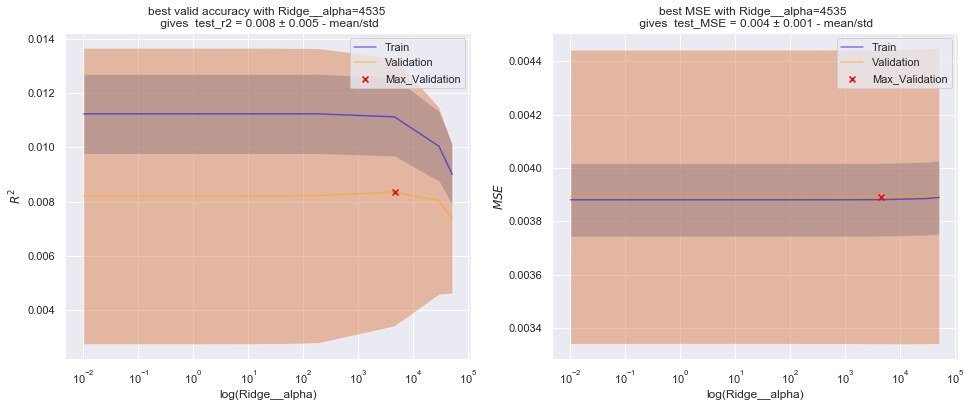

/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,param_Ridge__alpha,std_train_r2,mean_train_r2,std_validation_r2,mean_validation_r2,std_train_MSE,mean_train_MSE,std_validation_MSE,mean_validation_MSE,Model
2,4534.88,0.001456,0.011129,0.004957,0.008354,0.000138,0.003881,0.000552,0.003892,Ridge


In [37]:
# Plot the validation curves (R2 & MSE vs. paramater) for the Ridge regression
result_Ridge = sortout_data(params_Ridge[0], grid_Ridge, random_search_Ridge, log=True)
result_Ridge

In [38]:
# Apply the results of the optimized grid search to the test data
#R2
Ridge_test_score = random_search_Ridge.score(X_te, y_te)
print('The test_r2 for Ridge based on best parameter from grid search: {:.4f}'.format(Ridge_test_score))

#MSE
y_pred_Ridge= result_Ridge_grid.predict(X_te)
print('The test_MSE for Ridge based on best parameter from grid search: {:.6f}'.format(MSE(y_pred_Ridge,y_te)))

The test_r2 for Ridge based on best parameter from grid search: 0.0074
The test_MSE for Ridge based on best parameter from grid search: 0.006570


In [39]:
results_Ridge_test = pd.DataFrame({'Model':'Ridge',
                                   'mean_test_r2':[Ridge_test_score],
                                   'mean_test_MSE':[MSE(y_pred_Ridge,y_te)]})
results_Ridge_test

,Model,mean_test_r2,mean_test_MSE
0,Ridge,0.007382,0.00657


In [40]:
results_Ridge = result_Ridge.merge(results_Ridge_test,how='left', left_on='Model', right_on='Model')
# Rearrange the columns
cols=  ['Model', 'param_Ridge__alpha', 'mean_train_r2', 'std_train_r2','mean_validation_r2','std_validation_r2',
        'mean_test_r2','mean_train_MSE','std_train_MSE','mean_validation_MSE', 'std_validation_MSE', 'mean_test_MSE']
results_Ridge = results_Ridge[cols]
results_Ridge

,Model,param_Ridge__alpha,mean_train_r2,std_train_r2,mean_validation_r2,std_validation_r2,mean_test_r2,mean_train_MSE,std_train_MSE,mean_validation_MSE,std_validation_MSE,mean_test_MSE
0,Ridge,4534.88,0.011129,0.001456,0.008354,0.004957,0.007382,0.003881,0.000138,0.003892,0.000552,0.00657


In [41]:
# Manual grid search for the Ridge Regression

#cv_results=[]

#N=3
#for idx_run in range(0, N):
              
#        scaler = StandardScaler()
#        X_tr = scaler.fit_transform(X_tr)
#        X_te = scaler.transform(X_te)
        
#        print('step executed {} out of {}'.format(idx_run+1,N+1))

#        for a in np.logspace(1, 4, num=100):
            
#            model = Ridge(alpha=a) # Ridge compared to LinearRegression, Huber and Lasso seems to be the best compromise after several runs#            model.fit(X_tr,y_tr)
#            model.fit(X_tr,y_tr)
#            y_pred_tr = np.maximum(model.predict(X_tr), 0)
#            y_pred_te = np.maximum(model.predict(X_te),0)

#            cv_results.append({'param_Ridge__alpha': a,
#                               'idx_run': idx_run,
#                               'mean_train_r2': model.score(X_tr,y_tr),
#                               'mean_test_r2': model.score(X_te, y_te),
#                               'mean_train_neg_mean_squared_error': MSE(y_tr, y_pred_tr), 
#                               'mean_test_neg_mean_squared_error':  MSE(y_te,y_pred_te), 
#            })
        
#cv_results_manu = pd.DataFrame(cv_results)
#cv_results_manu = cv_results_manu[['idx_run','param_Ridge__alpha', 'mean_train_neg_mean_squared_error', 'mean_train_r2', 
#                         'mean_test_neg_mean_squared_error', 'mean_test_r2',]]
#cv_results_manu = cv_results_manu.loc[1:,:]
#cv_results_manu.head()

> **Remarks**:
<br> - The results did not display very good results, and we don't improve a lot the results by tuning the hyperparameter `alpha` for regularization compared to the simple approach with the `LinearRegression` (without any hyperparameter) since r2_test and MSE_test remain in the same order of magnitude.
<br> - We saw overfitting as there is a constant gap between the train and validation curves; in addition, the std of the validation dataset shows a bigger pattern than the one from the training dataset, meaning that the model is not robust enough on the unseen data and the train data are taken too much noise maybe too much variance.
<br> - The result of the r2 is very low. Is it due to the poor data quality from EDA or to the fact that the data cannot be approximated by a linear approach, or is r2 not adequate information?
<br> - Linear regression does not seem to be the right approach for fitting the data; although we are dealing with not a very large set of features, the collinearity does not seem to exist based on EDA but we keep many outliers in the dataset.

### 3.10 K-NN --> See other file: 03.1.Knn-ML-jeromeaubry.ipynb

In [79]:
from sklearn.neighbors import KNeighborsRegressor

In [80]:
#Create a pipeline
#pipe_knn = Pipeline([
#    ('scaler', scale), 
#    ('knn', KNeighborsRegressor(algorithm='brute')) 
#])

# Create a grid search
#k_values = np.arange(1,121,20)

#grid_knn = {
#    'knn__n_neighbors': k_values,
#    'knn__weights':['uniform','distance'],
#    'knn__p':[1,2]
#}

In [ ]:
# Use GridSearchCV for optimization

#random_search_knn = RandomizedSearchCV(pipe_knn, grid_knn, cv=3, verbose=10, n_jobs=-1, refit='r2',  #Maximize r2
#                                    random_state=random_state, return_train_score=True, scoring=['neg_mean_squared_error', 'r2']) # Sort out r2 and MSE



#grid_search_knn = GridSearchCV(pipe_knn, grid_knn, cv=3, verbose=10, n_jobs=-1, refit='r2',  #Maximize r2
#                                 return_train_score=True, scoring=['neg_mean_squared_error', 'r2']) # optimize r2 and MSE

#tuned_search_knn  = TuneSearchCV(pipe_knn, grid_knn, early_stopping=True, scoring=['neg_mean_squared_error', 'r2'], n_jobs=-1,
#                                  refit='r2', cv=5, verbose=2, return_train_score=True, max_iters=3, search_optimization='random')
                                 
#result_knn_grid = random_search_knn.fit(X_tr, y_tr)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tos

In [ ]:
# Sortout the best parameters
#params_knn = sortout_params(grid_knn, random_search_knn)
#params_knn

In [ ]:
#result_knn = sortout_data(params_knn[0], grid_knn, random_search_knn, log=False)
#result_knn

In [ ]:
# Apply the results of the grid search to the test data
#knn_test_score = random_search_knn.score(X_te, y_te)
#knn_test_score

In [ ]:
# Apply the results of the optimized grid search to the test data
#R2
#knn_test_score = random_search_knn.score(X_te, y_te)
#print('The test_r2 for rf based on best parameter from grid search: {:.4f}'.format(knn_test_score))

#MSE
#y_pred_knn= result_knn_grid.predict(X_te)
#print('The test_MSE for rf  based on best parameter from grid search: {:.6f}'.format(MSE(y_pred_knn,y_te)))

In [ ]:
#results_knn_test = pd.DataFrame({'Model':'knn',
#                                   'mean_test_r2':[knn_test_score],
#                                   'mean_test_MSE':[MSE(y_pred_knn,y_te)]})
#results_knn_test

In [ ]:
#results_knn = result_knn.merge(results_knn_test,how='left', left_on='Model', right_on='Model')

#cols=  ['Model', 'param_knn__p', 'param_knn__weights', 'param_knn__n_neighbors', 'mean_train_r2', 'std_train_r2','mean_validation_r2','std_validation_r2',
#        'mean_test_r2','mean_train_MSE','std_train_MSE','mean_validation_MSE', 'std_validation_MSE', 'mean_test_MSE']
#results_knn = results_knn[cols]
#results_knn

### 3.11. Non-Linear Approach: SVR: Supervised Vector Machine Approach for Regression

In [50]:
# Call the necessary librairies
from sklearn.svm import SVR

In [51]:
# Create a pipeline and a gridsearch
%time
pipe_SVR = Pipeline([
    ('scale',scale),
    ('SVR',SVR())
])

C_values = [0.1,1,10,20]
grid_SVR = {
    'SVR__C': C_values,
    'SVR__kernel':['rbf']
}


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11.9 µs


In [52]:
list(pipe_SVR.get_params())

['memory',
 'steps',
 'scale',
 'SVR',
 'scale__copy',
 'scale__with_mean',
 'scale__with_std',
 'SVR__C',
 'SVR__cache_size',
 'SVR__coef0',
 'SVR__degree',
 'SVR__epsilon',
 'SVR__gamma',
 'SVR__kernel',
 'SVR__max_iter',
 'SVR__shrinking',
 'SVR__tol',
 'SVR__verbose']

In [53]:
random_search_SVR = RandomizedSearchCV(pipe_SVR, grid_SVR, cv=3, verbose=20, n_jobs=-1, refit='r2',  #Maximize r2
                                       random_state=random_state, return_train_score=True, 
                                       scoring=['neg_mean_squared_error', 'r2']) # Optimize MSE; r2

#grid_search_SVR = GridSearchCV(pipe_SVR, grid_SVR, cv=2, verbose=20, n_jobs=-1, refit='r2',
#                              return_train_score=True,scoring=['neg_mean_squared_error','r2'])

result_SVR_grid = random_search_SVR.fit(X_tr,y_tr)

/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is depre

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:   22.6s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:   22.6s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:   23.5s remaining:   47.1s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:   24.1s remaining:   33.8s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:   25.1s remaining:   25.1s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  1.7min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed:  1.9min remaining:   55.7s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  2.3min remaining:   45.8s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  2.9min remaining:   34.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.2min finished


In [54]:
# Sortout the best parameters
params_SVR = sortout_params(grid_SVR, random_search_SVR)
params_SVR

Best parameters: {'SVR__kernel': 'rbf', 'SVR__C': 10}
--------------------------------------------------
Best estimators: Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SVR', SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])
--------------------------------------------------
Best score: -0.5257424939170345
--------------------------------------------------


['SVR__C', 'SVR__kernel']

In [55]:
params_SVR[0]

'SVR__C'

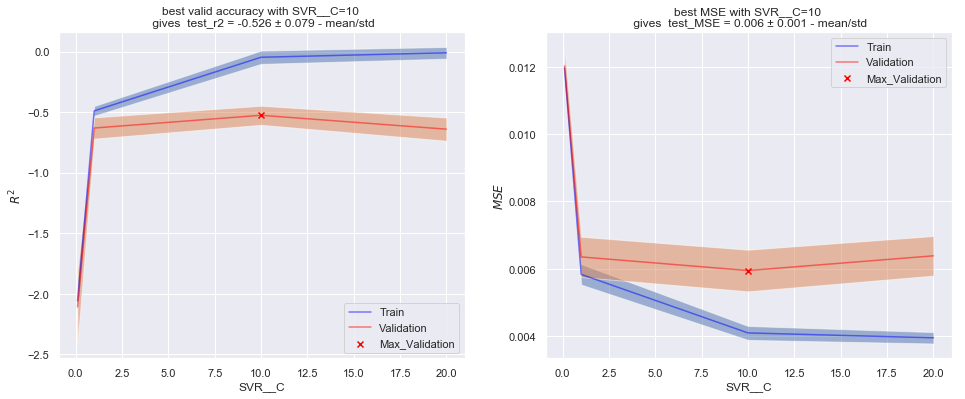

/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,param_SVR__kernel,param_SVR__C,std_train_r2,mean_train_r2,std_validation_r2,mean_validation_r2,std_train_MSE,mean_train_MSE,std_validation_MSE,mean_validation_MSE,Model
2,rbf,10,0.054617,-0.046637,0.078562,-0.525742,0.000206,0.004097,0.000618,0.005949,SVR


In [56]:
#Plot the data with C parameter as X_axis
result_SVR = sortout_data(params_SVR[0], grid_SVR, random_search_SVR, log=False)
result_SVR

In [57]:
# Apply the results of the optimized grid search to the test data
#R2
SVR_test_score = random_search_SVR.score(X_te, y_te)
print('The test_r2 for SVR based on best parameter from grid search: {:.4f}'.format(SVR_test_score))

#MSE
y_pred_SVR= result_SVR_grid.predict(X_te)
print('The test_MSE for SVR  based on best parameter from grid search: {:.6f}'.format(MSE(y_pred_SVR,y_te)))

The test_r2 for SVR based on best parameter from grid search: -0.2935
The test_MSE for SVR  based on best parameter from grid search: 0.008561


In [58]:
results_SVR_test = pd.DataFrame({'Model':'SVR',
                                   'mean_test_r2':[SVR_test_score],
                                   'mean_test_MSE':[MSE(y_pred_SVR,y_te)]})
results_SVR_test

,Model,mean_test_r2,mean_test_MSE
0,SVR,-0.293461,0.008561


In [59]:
results_SVR = result_SVR.merge(results_SVR_test,how='left', left_on='Model', right_on='Model')
# Rearrange the columns
cols=  ['Model', 'param_SVR__kernel', 'param_SVR__C', 'mean_train_r2', 'std_train_r2','mean_validation_r2','std_validation_r2',
        'mean_test_r2','mean_train_MSE','std_train_MSE','mean_validation_MSE', 'std_validation_MSE', 'mean_test_MSE']
results_SVR = results_SVR[cols]
results_SVR

,Model,param_SVR__kernel,param_SVR__C,mean_train_r2,std_train_r2,mean_validation_r2,std_validation_r2,mean_test_r2,mean_train_MSE,std_train_MSE,mean_validation_MSE,std_validation_MSE,mean_test_MSE
0,SVR,rbf,10,-0.046637,0.054617,-0.525742,0.078562,-0.293461,0.004097,0.000206,0.005949,0.000618,0.008561


> **Remarks**:
<br> - We use the option Gaussian Radial Basis Function `RBF` as the kernel for the SVM regression acting as a non-linear regression.
<br> - The parameter `C`is tuned and acts similar to the factor `alpha` for the Ridge Regression; it is a regularization parameter if the model overfits `C` should be reduced and vice-versa for the underfitting case. The margin `epsilon` is set to 0.1 per default as representing the width/margin of the "tube" where the SVM Regression tries to fit as many instances as possible within this tube while limiting the margin violations.
<br> - The optimum for the train and test data is`C`=10, but the resolution is not so big since we down-select 4 values for optimizing due to the time-consuming process
<br> - The level of std for the validation data is again slightly bigger than for the train data.
<br> - Again, the results are very mediocre, r2 is even negative, and MSE results are worst than for the linear regression; although the algorithm shows an optimum value, increasing `C` lead to the improvement of the training data while the validation decreases meaning an overfitting problem, this means a high variance but in addition, the model performs poorly for fitting the data.

### 3.12.Non Linear Approach: Random Forest 

In [40]:
from sklearn.ensemble import RandomForestRegressor 

In [41]:
# Create a pipeline and a gridsearch
pipe_rf = Pipeline([
    ('scale',scale),
    ('rf', RandomForestRegressor())
])
max_depth_values = np.arange(1,50,1)
#max_depth_values = np.logspace(-1, 4, num=50)
n_estimator_values = [1,10,100]

grid_rf ={
    'rf__max_depth': max_depth_values,
    'rf__n_estimators': n_estimator_values 
}

In [42]:
list(pipe_rf.get_params())

['memory',
 'steps',
 'scale',
 'rf',
 'scale__copy',
 'scale__with_mean',
 'scale__with_std',
 'rf__bootstrap',
 'rf__criterion',
 'rf__max_depth',
 'rf__max_features',
 'rf__max_leaf_nodes',
 'rf__min_impurity_decrease',
 'rf__min_impurity_split',
 'rf__min_samples_leaf',
 'rf__min_samples_split',
 'rf__min_weight_fraction_leaf',
 'rf__n_estimators',
 'rf__n_jobs',
 'rf__oob_score',
 'rf__random_state',
 'rf__verbose',
 'rf__warm_start']

In [43]:
#grid_search_rf = GridSearchCV(pipe_rf,grid_rf,cv=5,verbose=20,n_jobs=-1,refit='r2', 
#                              return_train_score=True, scoring=['neg_mean_squared_error', 'r2'])

random_search_rf = RandomizedSearchCV(pipe_rf,grid_rf, cv=3, verbose=10, n_jobs=-1, refit='r2',  #Maximize r2
                                 random_state=random_state, return_train_score=True, scoring=['neg_mean_squared_error', 'r2']) # Sort out r2 and MSE

result_rf_grid = random_search_rf.fit(X_tr,y_tr)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tos

In [46]:
# Sortout the best parameters
params_rf = sortout_params(grid_rf, random_search_rf)
params_rf

Best parameters: {'rf__n_estimators': 100, 'rf__max_depth': 5}
--------------------------------------------------
Best estimators: Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])
--------------------------------------------------
Best score: 0.03170266643846897
--------------------------------------------------


['rf__max_depth', 'rf__n_estimators']

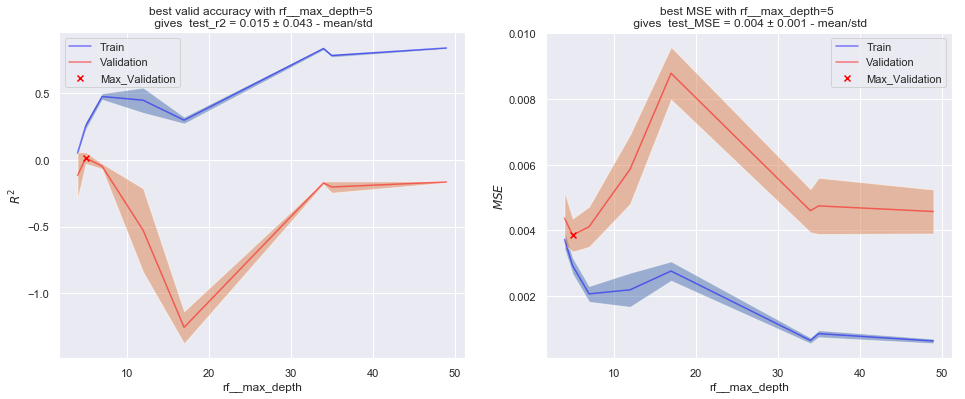

/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,param_rf__n_estimators,param_rf__max_depth,std_train_r2,mean_train_r2,std_validation_r2,mean_validation_r2,std_train_MSE,mean_train_MSE,std_validation_MSE,mean_validation_MSE,Model
6,100,5,0.027598,0.255937,0.024927,0.031703,0.000262,0.002922,0.000490,0.003792,rf
7,10,5,0.031000,0.256159,0.060740,-0.002467,0.000235,0.002918,0.000521,0.003923,rf


In [57]:
result_rf = sortout_data(params_rf[0], grid_rf, random_search_rf, log=False)
result_rf

In [53]:
# Apply the results of the optimized grid search to the test data
#R2
rf_test_score = random_search_rf.score(X_te, y_te)
print('The test_r2 for rf based on best parameter from grid search: {:.4f}'.format(rf_test_score))

#MSE
y_pred_rf= result_rf_grid.predict(X_te)
print('The test_MSE for rf  based on best parameter from grid search: {:.6f}'.format(MSE(y_pred_rf,y_te)))

The test_r2 for rf based on best parameter from grid search: 0.0352
The test_MSE for rf  based on best parameter from grid search: 0.006386


In [54]:
results_rf_test = pd.DataFrame({'Model':'rf',
                                'mean_test_r2':[rf_test_score],
                                'mean_test_MSE':[MSE(y_pred_rf,y_te)]})
results_rf_test

,Model,mean_test_r2,mean_test_MSE
0,rf,0.035193,0.006386


In [55]:
results_rf = result_rf.merge(results_rf_test,how='left', left_on='Model', right_on='Model')
# Rearrange the columns
cols=  ['Model', 'param_rf__n_estimators','param_rf__max_depth', 'mean_train_r2', 'std_train_r2','mean_validation_r2','std_validation_r2',
        'mean_test_r2','mean_train_MSE','std_train_MSE','mean_validation_MSE', 'std_validation_MSE', 'mean_test_MSE']
results_rf = results_rf[cols]
results_rf

,Model,param_rf__n_estimators,param_rf__max_depth,mean_train_r2,std_train_r2,mean_validation_r2,std_validation_r2,mean_test_r2,mean_train_MSE,std_train_MSE,mean_validation_MSE,std_validation_MSE,mean_test_MSE
0,rf,100,5,0.255937,0.027598,0.031703,0.024927,0.035193,0.002922,0.000262,0.003792,0.000490,0.006386
1,rf,10,5,0.256159,0.031000,-0.002467,0.060740,0.035193,0.002918,0.000235,0.003923,0.000521,0.006386


> **Remarks**:
<br> - We saw a tendency to overfit in the previous models; the actual random forest is a random and non-linear algorithm reducing the variance by averaging the prediction from several instances as it trains on different samples of the dataset (averaging method of the variance). 
<br> - The grid search optimization has been done on multi-parameters such as `max_depth` represenitng the depth of the trees and `n_estimator` which is the number of trees. As a result, the optimization is around 5 and 100, respectively. The more we increase `max_depth`, the more complex the model is and the worst the results are.
<br> - The results are a very high training dataset and very low validation dataset, as if the model doesn't learn from the data and has a very high bias. The curves fluctuate between extreme values, meaning the optimum values could jump significantly. Is it an artefact? It seems that it is not reproducible. 
<br> - The r2 and MSE values on the test data give a slightly better compared to other models but again the model does not perform well for fitting the data.

### 3.13.Gradient Boosting

In [61]:
from sklearn.ensemble import GradientBoostingRegressor

In [62]:
# Create a pipeline and a gridsearch
pipe_gbr= Pipeline([
    ('scale',scale),
    ('gbr', GradientBoostingRegressor())
])
GradientBoostingRegressor
max_depth_values = np.arange(1,100,2)
#max_depth_values = np.logspace(-1, 4, num=50)
n_estimator_values = [1,10,100]
learning_rate = [0.1,1]


grid_gbr ={
    'gbr__max_depth': max_depth_values,
    'gbr__n_estimators': n_estimator_values,
    'gbr__learning_rate':learning_rate

}

In [63]:
list(pipe_gbr.get_params())

['memory',
 'steps',
 'scale',
 'gbr',
 'scale__copy',
 'scale__with_mean',
 'scale__with_std',
 'gbr__alpha',
 'gbr__criterion',
 'gbr__init',
 'gbr__learning_rate',
 'gbr__loss',
 'gbr__max_depth',
 'gbr__max_features',
 'gbr__max_leaf_nodes',
 'gbr__min_impurity_decrease',
 'gbr__min_impurity_split',
 'gbr__min_samples_leaf',
 'gbr__min_samples_split',
 'gbr__min_weight_fraction_leaf',
 'gbr__n_estimators',
 'gbr__n_iter_no_change',
 'gbr__presort',
 'gbr__random_state',
 'gbr__subsample',
 'gbr__tol',
 'gbr__validation_fraction',
 'gbr__verbose',
 'gbr__warm_start']

In [64]:
random_search_gbr = RandomizedSearchCV(pipe_gbr,grid_gbr, cv=3, verbose=10, n_jobs=-1, refit='r2',  #Maximize r2
                                 random_state=random_state, return_train_score=True, scoring=['neg_mean_squared_error', 'r2']) # Sort out, optimize r2 and MSE

result_gbr_grid = random_search_gbr.fit(X_tr,y_tr)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tos

In [65]:
# Sortout the best parameters
params_gbr = sortout_params(grid_gbr, random_search_gbr)
params_gbr

Best parameters: {'gbr__n_estimators': 100, 'gbr__max_depth': 47, 'gbr__learning_rate': 0.1}
--------------------------------------------------
Best estimators: Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbr', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=47, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
     ...one, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))])
--------------------------------------------------
Best score: -0.9889407752662336
--------------------------------------------------


['gbr__learning_rate', 'gbr__max_depth', 'gbr__n_estimators']

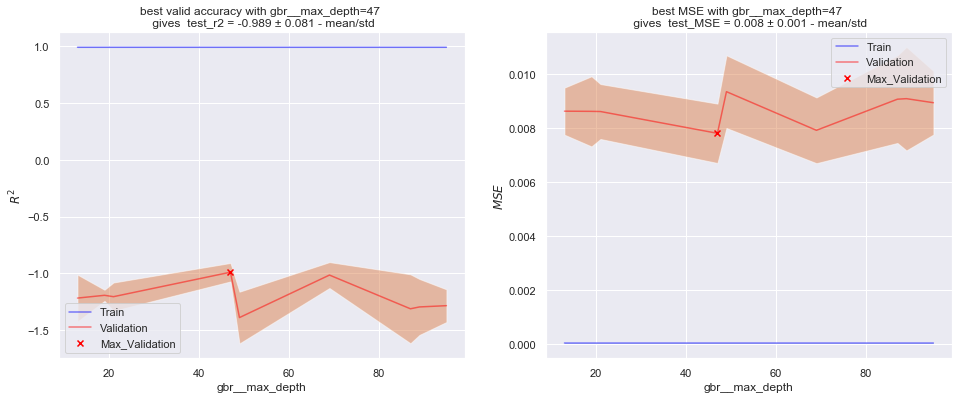

/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,param_gbr__n_estimators,param_gbr__max_depth,param_gbr__learning_rate,std_train_r2,mean_train_r2,std_validation_r2,mean_validation_r2,std_train_MSE,mean_train_MSE,std_validation_MSE,mean_validation_MSE,Model
0,100,47,0.1,0.003232,0.992005,0.081339,-0.988941,0.000015,0.000032,0.001099,0.007799,gbr


In [66]:
result_gbr = sortout_data(params_gbr[1], grid_gbr, random_search_gbr, log=False)
result_gbr 

In [67]:
# Apply the results of the optimized grid search to the test data
#R2
gbr_test_score = random_search_gbr.score(X_te, y_te)
print('The test_r2 for rf based on best parameter from grid search: {:.4f}'.format(gbr_test_score))

#MSE
y_pred_gbr= result_gbr_grid.predict(X_te)
print('The test_MSE for rf  based on best parameter from grid search: {:.6f}'.format(MSE(y_pred_gbr,y_te)))

The test_r2 for rf based on best parameter from grid search: -0.3367
The test_MSE for rf  based on best parameter from grid search: 0.008847


In [68]:
results_gbr_test = pd.DataFrame({'Model':'gbr',
                                   'mean_test_r2':[gbr_test_score],
                                   'mean_test_MSE':[MSE(y_pred_gbr,y_te)]})
results_gbr_test

,Model,mean_test_r2,mean_test_MSE
0,gbr,-0.336708,0.008847


In [69]:
results_gbr = result_gbr.merge(results_gbr_test,how='left', left_on='Model', right_on='Model')
# Rearrange the columns
cols=  ['Model', 'param_gbr__n_estimators', 'param_gbr__max_depth', 'param_gbr__learning_rate','mean_train_r2', 'std_train_r2','mean_validation_r2','std_validation_r2',
        'mean_test_r2','mean_train_MSE','std_train_MSE','mean_validation_MSE', 'std_validation_MSE', 'mean_test_MSE']
results_gbr = results_gbr[cols]
results_gbr

,Model,param_gbr__n_estimators,param_gbr__max_depth,param_gbr__learning_rate,mean_train_r2,std_train_r2,mean_validation_r2,std_validation_r2,mean_test_r2,mean_train_MSE,std_train_MSE,mean_validation_MSE,std_validation_MSE,mean_test_MSE
0,gbr,100,47,0.1,0.992005,0.003232,-0.988941,0.081339,-0.336708,0.000032,0.000015,0.007799,0.001099,0.008847


> **Remarks**:
<br> - It has been decided to test a new method apart from the one seen in the course. A reasonable approach was to consider the model ?`GradienBoostingRegressor`, which could be seen as an extension of the model RandomForestRegressor. 
<br> - Indeed, the algo works sequentially by adding predictors to an ensemble, each one correcting the predecessor. The hyperparameters are similar to the ones from the RandomeForest, i.e.`max_depth` for the depth of the trees and the number of trees is represented by `n_estimators`. In addition, the parameter `learning_rate`
 scales the contribution to each tree; a low value means more trees in the ensemble for fitting the training data. 
<br> - As a result, we obtain similar results to the random forest, i.e. a huge gap between the train data and the validation data as the model doesn't learn from the data, huge bias, and, suddenly, a small jump of the curve where the optimum is set to `n_estimator`=100 (one tree), `max_dept`= 47 with `learing_rate`=0.1 but not reproducible at all. The model is not suitable at all for the present data.

### 3.14 Save Results

In [ ]:
# Save the Baseline
results_baseline.to_csv ('baseline.csv', encoding='utf-8', float_format='%.4f', index=False)

# Save the lr results
results_lr.to_csv ('lr_option3_EDA_1.csv', encoding='utf-8', float_format='%.4f', index=False)

# Save Ridge Results
results_Ridge.to_csv('lr_Ridge_option3_EDA_1.csv', encoding='utf-8', float_format='%.4f', index=False)

# Save Knn Results
#results_knn.to_csv('knn_option3_EDA.csv', encoding='utf-8', float_format='%.4f', index=False)

#Save SVR Results
results_SVR.to_csv('SVR_option3_EDA_1.csv', encoding='utf-8', float_format ='%.4f', index=False)

#Save rf results
results_rf.to_csv('RandomForest_3_EDA_1.csv', encoding='utf-8', float_format ='%.4f', index=False)

#Save gbr results
results_gbr.to_csv('GradienBoostingRegressor_3_EDA_1.csv', encoding='utf-8', float_format ='%.4f', index=False)